In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from mpl_toolkits.basemap import Basemap
import contextily as ctx
import folium
import pyproj
from IPython.display import HTML, display
from itertools import cycle

### Create a parser for useful columns (fields) from IBTracs Dataset and process 2000 rows at a time (chunksize)

In [2]:
# fields = {'SID', 'YEAR', 'BASIN', 'SUBBASIN', 'NAME', 'LAT', 'LON', 'WMO_WIND' 'STORM_SPEED', 'STORM_DIR'} # -- {0,1,2,3,4,8,9,10,161,162}
df_chunks = pd.read_csv('./ibtracs.ALL.list.v04r00.csv', chunksize=2000, usecols=[0,1,2,3,4,7,8,9,10,161,162], engine='python')

df_chunks

### Chunks are loaded into an array together and made into a datafile (df)

In [3]:
mylist = []
for chunk in df_chunks:
    mylist.append(chunk)

In [4]:
df = pd.concat(mylist, axis= 0)

#### The dataset columns and size and datatypes

In [6]:
df

,SID,YEAR,NUMBER,BASIN,SUBBASIN,LAT,LON,WMO_WIND,STORM_SPEED,STORM_DIR
0,1845336N10074,1845,1,NI,AS,10.0000,74.3000,,3,283
1,1845336N10074,1845,1,NI,AS,10.0329,74.1547,,3,284
2,1845336N10074,1845,1,NI,AS,10.0725,74.0075,,3,288
3,1845336N10074,1845,1,NI,AS,10.1260,73.8566,,3,293
4,1845336N10074,1845,1,NI,AS,10.2000,73.7000,,4,299
...,...,...,...,...,...,...,...,...,...,...
689491,2019364S19060,2020,102,SI,MM,-26.9000,60.5000,,21,169
689492,2019364S19060,2020,102,SI,MM,-28.0150,60.7772,,23,166
689493,2019364S19060,2020,102,SI,MM,-29.1000,61.1000,,20,163
689494,2019364S19060,2020,102,SI,MM,-29.9326,61.4446,,16,158


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689496 entries, 0 to 689495
Data columns (total 12 columns):
SID            689496 non-null object
YEAR           689496 non-null int64
NUMBER         689496 non-null int64
BASIN          569765 non-null object
SUBBASIN       598188 non-null object
NATURE         689496 non-null object
LAT            689496 non-null float64
LON            689496 non-null float64
WMO_WIND       689496 non-null object
STORM_SPEED    689496 non-null object
STORM_DIR      689496 non-null object
geometry       689496 non-null geometry
dtypes: float64(2), geometry(1), int64(2), object(7)
memory usage: 42.1+ MB


#### Ranges for Latitude and Longitude from dataset

In [5]:
crs = {'init':'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(df['LON'], df['LAT'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry).to_crs(epsg=3857)

c:\program files (x86)\python38-32\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


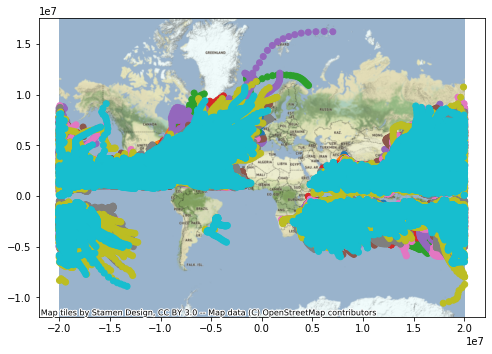

In [133]:
fig, ax = plt.subplots(figsize = (8,8))

geo_df.plot(ax = ax,column='SID')
ctx.add_basemap(ax)

## Plotting an individual Cyclone on SID (Storm ID)

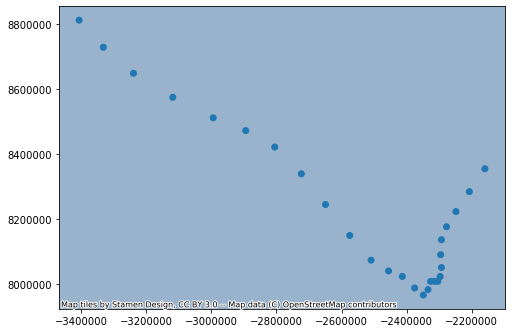

In [129]:
gk = df.groupby('SID').get_group('2019364S19060')

crs = {'init':'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(gk['LAT'], gk['LON'])]
geo_df_gk = gpd.GeoDataFrame(gk, crs = crs, geometry = geometry).to_crs(epsg=3857)

figGroup1, axGroup1 = plt.subplots(figsize = (8,12))
geo_df_gk.plot(ax = axGroup1,column='SID')
ctx.add_basemap(axGroup1)

## Plotting separate maps for each group of SID (Storm IDs)

In [130]:
import warnings
warnings.filterwarnings("ignore")

[XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX]


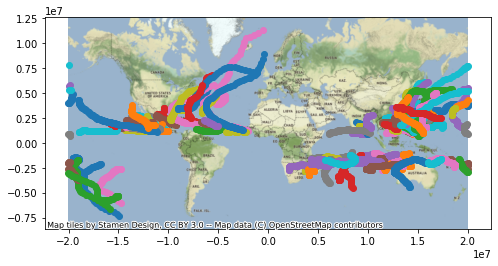

In [142]:
gks = df.groupby('SID')

crs = {'init':'epsg:4326'}
fig_gks, ax_gks = plt.subplots(figsize = (8,12))

SID_2000 = df[df['SID'].notnull() & (df['YEAR'] == 2000)]
SIDS = set(SID_2000['SID'])


colors = cycle(["aqua", "black", "blue", "fuchsia", "gray", "green", "lime", "maroon", "navy", "olive", "purple", "red", "silver", "teal", "yellow"])

counter = 0
print("[", end='')
for SID in SIDS:
    Storm = gks.get_group(SID)
    if counter == 20: break
    print("X", end ='')
        
    geometry = [Point(x,y) for x,y in zip(Storm['LON'],Storm['LAT'])]
    geo_df_gk = gpd.GeoDataFrame(Storm, crs = crs, geometry = geometry).to_crs(epsg=3857)
    ax_gks.plot(Storm['LON'], Storm['LAT'], label="ID:" + SID, color=next(colors))
    geo_df_gk.plot(ax = ax_gks)
print("]")
ctx.add_basemap(ax_gks)
    
    
    
    

## Utilising conversion to EPSG:4326, WIP: Plotting Points Overrided Error

In [ ]:
fig2, ax2 = plt.subplots(figsize = (8,12))
geo_df.plot(ax = ax2,column='SID')
#ctx.add_basemap(ax2)

xmin, ymin, xmax, ymax = geo_df.total_bounds
url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=8, url=url)

reproject = lambda x, y: pyproj.transform(pyproj.Proj(init='EPSG:3857'),
                                          pyproj.Proj(init='EPSG:4326'), x, y)
x1, y1 = reproject(extent[0], extent[2])
x2, y2 = reproject(extent[1], extent[3])
wgs84_extent = x1, x2, y1, y2

ax2.imshow(basemap, extent=wgs84_extent, interpolation='bilinear')

#### Interactive Folium Map

DS - Disturbance 
TS - Tropical {5,4,3,2,1,Storm,Depression}
ET - Extratropical 
SS - Subtropical 
NR - Not reported 
MX - Mixture (contradicting nature reports from different agencies)


In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from IPython.display import HTML, display
from itertools import cycle
from geopy.distance import great_circle

In [2]:
# fields = {'SID', 'YEAR', 'BASIN', 'SUBBASIN', 'NAME', 'LAT', 'LON', 'WMO_WIND' 'STORM_SPEED', 'STORM_DIR'} # -- {0,1,2,3,4,8,9,10,161,162}
df_chunks = pd.read_csv('./ibtracs.ALL.list.v04r00.csv', chunksize=2000, usecols=[0,1,2,3,4,7,8,9,10,161,162], engine='python')
mylist = []
for chunk in df_chunks:
    mylist.append(chunk)
    
df = pd.concat(mylist, axis= 0)

In [7]:
crs = {'init':'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(df['LON'], df['LAT'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry).to_crs(epsg=3857)

c:\program files (x86)\python38-32\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [8]:
Map = folium.Map(location=[50.71984,-3.53019], zoom_start=2)
selected = []
selected.append(geo_df[geo_df["SID"] == "2019364S19060"])
selected.append(geo_df[geo_df["SID"] == "1975266N10325"])
selected.append(geo_df[geo_df["SID"] == "1845336N10074"])
selected.append(geo_df[geo_df["SID"] == "2000141N24130"])
selected.append(geo_df[geo_df["SID"] == "2000006S15164"])
selected.append(geo_df[geo_df["SID"] == "2000058S14063"])
selected.append(geo_df[geo_df["SID"] == "2000056S17152"])
selected.append(geo_df[geo_df["SID"] == "2000205N10260"])
selected.append(geo_df[geo_df["SID"] == "2000249N15258"])

In [9]:
colors = {"NR":"blue","MX":"aqua","DS":"green","SS":"yellow","TS":"orange","ET":"red"}
counter = 0
for Storm in selected:
    counter += 1
    if counter == 10: break
    
    #Storm = geo_df[geo_df["SID"] == Storm]
    firstMarker = True

    if Storm["NATURE"].all() == "NR": StormColor = "blue"
    elif Storm["NATURE"].all() == "DS": StormColor = "green"
    elif Storm["NATURE"].all() == "SS": StormColor = "yellow"
    elif Storm["NATURE"].all() == "TS": StormColor = "orange"
    elif Storm["NATURE"].all() == "ET": StormColor = "red"
    elif Storm["NATURE"].any() == "MX": StormColor = "aqua"
    else: StormColor = "black"
        
    for LAT,LON,speed,direction in zip(Storm["LAT"],Storm["LON"],Storm["STORM_SPEED"], Storm["STORM_DIR"]):    
        if not firstMarker:
            folium.PolyLine(locations=[[prev_LAT,prev_LON],[LAT,LON]], color=StormColor).add_to(Map)
        folium.RegularPolygonMarker(location=[LAT,LON], color=StormColor, number_of_sides=3, radius=5, rotation=direction, popup="Speed: " + str(speed) + "m/s\n Direction: " + str(direction) + "°").add_to(Map)
        firstMarker = False
        prev_LAT = LAT
        prev_LON = LON

legend_html = '''
    <div style=”position: fixed; 
     bottom: 50px; left: 50px; width: 100px; height: 90px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     “>&nbsp; Cyclone Class <br>
     &nbsp; NR &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:blue”></i><br>
     &nbsp; MX &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:aqua”></i><br>
     &nbsp; DS &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:green”></i><br>
     &nbsp; SS &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:yellow”></i><br>
     &nbsp; TS &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:orange”></i><br>
     &nbsp; ET &nbsp; <i class=”fa fa-map-marker fa-2x”
                  style=”color:red”></i>
      </div>
    '''
     

Map.get_root().html.add_child(folium.Element(legend_html))

display(Map)

In [11]:
Map.save("MapExample.html")

In [3]:
crs = {'init':'epsg:4326'}
geometry = [Point(x,y) for x,y in zip(df['LON'], df['LAT'])]
geo_df_nearby = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

In [4]:
def within_distance_of(lat,lon,distance):
    nearby = []
    for SID,LON,LAT in zip(geo_df_nearby["SID"],geo_df_nearby["LON"],geo_df_nearby["LAT"]):
        if great_circle((lat,lon),(LAT,LON)).km < distance: nearby.append((SID,LAT,LON))
    return nearby

In [15]:
nearby = within_distance_of(-20.3484,57.5522,100)

In [16]:
MapNearby = folium.Map(location=[-20.3484,57.5522])

colors = cycle(["aqua", "black", "blue", "fuchsia", "gray", "green", "lime", "maroon", "navy", "olive", "purple", "red", "silver", "teal", "yellow"])
SIDColors = {}

for SID,LAT,LON in nearby:    
    if SID not in SIDColors:
        SIDColors[SID] = next(colors)

    folium.vector_layers.CircleMarker(location=[LAT,LON], color=SIDColors[SID], popup=str(SID), radius=8, fill_color='blue').add_to(MapNearby)
display(MapNearby)

In [ ]:
MapNearby.save("MapNearby.html")